In [1]:
#Libraries - all required except plt (just for checking and visualization) and mp (for viewing final model)
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr
import meshio
import meshplot as mp
import json
import subprocess
import colorsys

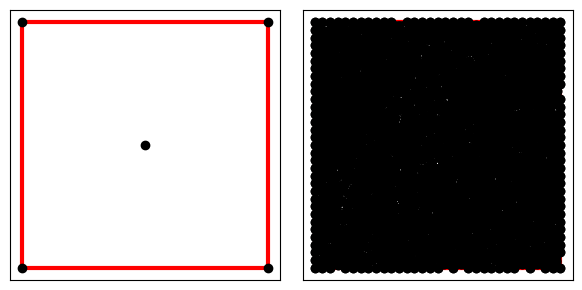

In [3]:
#Forming the object (manually)
pts0 = np.array(((0, 0), (10, 0), (10, 10), (0, 10))) #border
#pts1 = np.array(((3, 7), (2, 6), (2.5, 4), (4.5, 3), (6.5, 4), (8, 5), (7.5, 7), (6, 7.5), (5, 7), (4, 6), (4, 5), (5, 4), (6.5, 5), (6.5, 5.5), (5.5, 5), (5, 5.5), (5.5, 6.5), (6, 6)))
pts1 = np.array(((5, 5)))

pts = np.vstack([pts0, pts1]) #combined

#connecting points together (manually)
seg1 = np.array(((0, 1), (1, 2), (2, 3), (3, 0)))
# seg2 = []
# for i in range(4, len(pts1) + 3):
#     seg2.append((i, i+1))
# seg2 = np.array(seg2)
# seg_comb = [seg1, seg2]
# seg0 = np.vstack(seg_comb)
seg0 = np.vstack([seg1])

#indicies where segment meets up with beginning of shape--needed for random colour generation, but not manual
loop_backs = [3]
#indicies where segments are isolated
#iso_segs = [20]
iso_segs = []

#form mesh
A = dict(vertices=pts, segments=seg0)
meshObj = tr.triangulate(A, 'qpa0.05')
tr.compare(plt, A, meshObj)

In [4]:
#Helper function for solve() - determines if a float is between two other floats
def is_between(num, n1, n2):
    if (num <= n1 and num >= n2) or (num >= n1 and num <= n2):
        return True
    else:
        return False

    
#function that determines if a point is between two other points on the same line
def solve(coordinates) -> bool:
    (x0, y0), (x2, y2) = coordinates[0], coordinates[2]
    x1, y1 = coordinates[1]
    if (abs((x0 - x2) * (y2 - y1) - (x2 - x1) * (y0 - y2)) < 0.001) and (is_between(x1, x0, x2) and is_between(y1, y0, y2)):
        return True
    else:
        return False

In [5]:
#Plot ONLY points that are on a segment line
v = meshObj['vertices']

#create list of segments 
segment_lines = []
for line in seg0:
    segment_lines.append([v[line[0]], v[line[1]]])

all_dots_indexed = {}

red_dots = pts.tolist()
for d_i in range(len(red_dots)):
    all_dots_indexed[d_i] = red_dots[d_i]

green_dots = []
for p_i in range(len(v)):
    if v[p_i].tolist() not in red_dots:
        for l_i in range(len(seg0)):
            if solve([v[seg0[l_i][0]], v[p_i], v[seg0[l_i][1]]]):
                green_dots.append(v[p_i].tolist())
                all_dots_indexed[p_i] = v[p_i]

all_dots = []
all_dots += red_dots
all_dots += green_dots

In [5]:
# def is_left(P0, P1, Pc):
#     res = (P1[0] - P0[0]) * (Pc[1] - P0[1]) - (Pc[0] - P0[0]) * (P1[1] - P0[1])
#     if res > 0:
#         return True
#     else:
#         return False

# def what_side(seg, point):
#     seg_pt_1 = v[seg0[seg][0]]
#     seg_pt_2 = v[seg0[seg][1]]
#     res = is_left(seg_pt_1, seg_pt_2, point)
    
#     return res

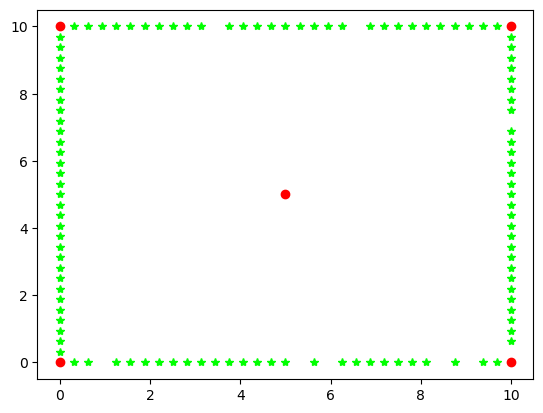

In [6]:
# gdr = []
# gdl = {}

# for seg in green_dots_loose:
#     for point in green_dots_loose[seg]:
#         if not what_side(seg, [point[0], point[1]]) and point not in gdr:
#             gdr.append(point)
#             if seg in gdl:
#                 gdl[seg].append([point[0], point[1]])
#             else:
#                 gdl[seg] = [[point[0], point[1]]]

# #FOR VIEWING TANGENTS to make sure it works (it works, I'm a fukkin genius)
gx = []
gy = []
for dot in green_dots:
    gx.append(dot[0])
    gy.append(dot[1])
    
rx = []
ry = []
for dot in red_dots:
    rx.append(dot[0])
    ry.append(dot[1])

# lx1 = []
# ly1 = []
# for dot in gdr:
#     lx1.append(dot[0])
#     ly1.append(dot[1])

plt.plot(gx, gy, '*', c=(0,1,0))
plt.plot(rx, ry, 'o', c=(1,0,0))
#plt.plot(lx1, ly1, '.', c=(0,0,0))

In [7]:
# for point in gdr:
#     all_dots.append([point[0], point[1]])
#     all_dots_indexed[point[2]] = [point[0], point[1]]

In [8]:
# seg_green_right = {}

# for p_i in range(len(all_dots) - len(gdr), len(all_dots)):
#     point = all_dots[p_i]
#     for seg in gdl:
#         if point in gdl[seg]:
#             if seg in seg_green_right:
#                 seg_green_right[seg].append([point[0], point[1], p_i])
#             else:
#                 seg_green_right[seg] = [[point[0], point[1], p_i]]

In [7]:
#Create dictionary where:
#key = corresponding segment index in segment_lines, value = list of triangle-generated points on that line
seg_green_left = {}

for line_index in range(len(segment_lines)):
    for p_i in range(len(green_dots)):
        if solve([segment_lines[line_index][0], green_dots[p_i], segment_lines[line_index][1]]):
            if line_index in seg_green_left:
                seg_green_left[line_index].append((green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots)))
            else:
                seg_green_left[line_index] = [(green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots))]

In [8]:
rgb_segs_left = []
#rgb_segs_right = []
                
#Generate RANDOM rgb values for manually plotted points
def random_colours(rgb_segs, seg_start):
    random_colour1 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    while random_colour1 == (0, 0, 0) or random_colour1 == (1, 1, 1):
        random_colour1 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    random_colour2 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    while random_colour2 == (0, 0, 0) or random_colour2 == (1, 1, 1):
        random_colour2 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    segm = [(segment_lines[seg_start][0][0], segment_lines[seg_start][0][1]), (segment_lines[seg_start][1][0], segment_lines[seg_start][1][1])]
    rgb_segs.append({"segment": segm, "colours": [random_colour1, random_colour2]})

    for segment_index in range(seg_start+1, len(segment_lines)):
        random_colour = np.random.randint(2), np.random.randint(2), np.random.randint(2)
        while random_colour == (0, 0, 0) or random_colour == (1, 1, 1):
            random_colour = np.random.randint(2), np.random.randint(2), np.random.randint(2)
        segm = [(segment_lines[segment_index][0][0], segment_lines[segment_index][0][1]), (segment_lines[segment_index][1][0], segment_lines[segment_index][1][1])]
        rgb_segs.append({"segment": segm, "colours": [rgb_segs[segment_index - (seg_start + 1)]["colours"][1], random_colour]})
    
    if len(loop_backs) > 0:
        i = 0
        while i < len(loop_backs) and loop_backs[i] < seg_start:
            i += 1
        if i < len(loop_backs):
            rgb_segs[loop_backs[0]]['colours'][1] = rgb_segs[0]['colours'][0]
            for loop_num_i in range(1, len(loop_backs)):
                rgb_segs[loop_backs[loop_num_i]]['colours'][1] = rgb_segs[loop_backs[loop_num_i - 1]+1]['colours'][0]

#Generate MANUALLY PLOTTED rgb values for manually plotted points
def fixed_colours(rgb_segs, cols, seg_start):    
    segm = [(segment_lines[seg_start][0][0], segment_lines[seg_start][0][1]), (segment_lines[seg_start][1][0], segment_lines[seg_start][1][1])]
    rgb_segs.append({"segment": segm, "colours": [cols[0], cols[1]]})

    for i in range(seg_start + 1, len(segment_lines)):
        segm = [(segment_lines[i][0][0], segment_lines[i][0][1]), (segment_lines[i][1][0], segment_lines[i][1][1])]
        rgb_segs.append({"segment": segm, "colours": [cols[i - (seg_start+1)], cols[i - seg_start]]})
        
    rgb_segs[loop_backs[0]]['colours'][1] = rgb_segs[0]['colours'][0]
    for loop_num_i in range(1, len(loop_backs)):
        rgb_segs[loop_backs[loop_num_i]]['colours'][1] = rgb_segs[loop_backs[loop_num_i - 1]+1]['colours'][0]

In [11]:
random_colours(rgb_segs_left, 0)
# random_colours(rgb_segs_right, 4)

In [9]:
fixed_colours(rgb_segs_left, [(1, 1, 1), (1, 1, 1), (1, 1, 1), (0, 0, 0)], 0)

In [12]:
# left_list = [(0.0, 1.0, 0.0), (0.0, 0.0, 1.0), (0.0, 1.0, 0.0)]
# for i in range(3, 22):
#     left_list.append((1.0, 0.0, 1.0))
# fixed_colours(rgb_segs_left, left_list, 0)

# right_list = []
# for i in range(4, 22):
#     right_list.append((0.0, 1.0, 1.0))
# fixed_colours(rgb_segs_right, right_list, 4)

In [10]:
#Convert to desired colourspace
isHsv = False
def hsv_interpolation(rgb_segs):
    global isHsv
    isHsv = True
    for seg in rgb_segs:
        col1 = seg['colours'][0]
        col2 = seg['colours'][1]
        seg['colours'] = []
        seg['colours'].append(colorsys.rgb_to_hsv(col1[0], col1[1], col1[2]))
        seg['colours'].append(colorsys.rgb_to_hsv(col2[0], col2[1], col2[2]))

In [11]:
#hsv_interpolation(rgb_segs_right)
#hsv_interpolation(rgb_segs_left)

In [12]:
rgb_points_left = []
#rgb_points_right = []
for i in range(len(all_dots)):
    rgb_points_left.append(None)

# for i in range(len(gdr)):
#     rgb_points_right.append(None)

def point_seg_align(rgb_points, rgb_segs, seg_start):
    i = 0
    while i < len(iso_segs) and iso_segs[i] < seg_start:
        i += 1
    if i < len(iso_segs):
        iso_count = 0
        for point_index in range(len(rgb_segs)):
            col = rgb_segs[point_index]['colours'][0]
            rgb_points[point_index + iso_count] = {"point": (red_dots[point_index + seg_start][0], red_dots[point_index + seg_start][1]), "colour": col}
            if point_index in iso_segs[i:]:
                col = rgb_segs[point_index]['colours'][1]
                iso_count += 1
                rgb_points[point_index + iso_count] = {"point": (red_dots[point_index + seg_start][0], red_dots[point_index + seg_start][1]), "colour": col}
    else:
        for point_index in range(seg_start, len(red_dots)):
            col = rgb_segs[point_index]['colours'][0]
            rgb_points[point_index] = {"point": (red_dots[point_index + seg_start][0], red_dots[point_index + seg_start][1]), "colour": col}

point_seg_align(rgb_points_left, rgb_segs_left, 0)
#point_seg_align(rgb_points_right, rgb_segs_right, 4)

IndexError: list index out of range

In [17]:
rgb_segs_left

[{'segment': [(0.0, 0.0), (10.0, 0.0)], 'colours': [(1, 1, 1), (1, 1, 1)]},
 {'segment': [(10.0, 0.0), (10.0, 10.0)], 'colours': [(1, 1, 1), (1, 1, 1)]},
 {'segment': [(10.0, 10.0), (0.0, 10.0)], 'colours': [(1, 1, 1), (1, 1, 1)]},
 {'segment': [(0.0, 10.0), (0.0, 0.0)], 'colours': [(1, 1, 1), (1, 1, 1)]}]

In [18]:
#Interpolate RGB values for all triangle-generated points
def interpolate_points(rgb_points, rgb_segs, segment_green_points, point_start, seg_start):
    for seg in segment_green_points:
        for point in segment_green_points[seg]:
            line = segment_lines[seg]
            line_height = abs(line[0][1] - line[1][1])
            line_width = abs(line[0][0] - line[1][0])
            rel_height = abs(point[1] - line[0][1])
            rel_width = abs(point[0] - line[0][0])
            ratio = max(rel_height, rel_width) / max(line_height, line_width)

            start_r, start_g, start_b = rgb_segs[seg - seg_start]["colours"][0]
            end_r, end_g, end_b = rgb_segs[seg - seg_start]["colours"][1]

            r = ((end_r - start_r) * ratio) + start_r
            g = ((end_g - start_g) * ratio) + start_g
            b = ((end_b - start_b) * ratio) + start_b
            
            if r < 0:
                r = 0
            elif r > 1:
                r = 1
            if g < 0:
                g = 0
            elif g > 1:
                g = 1
            if b < 0:
                b = 0
            elif b > 1:
                b = 1

            pnt_obj = {"point": (point[0], point[1]), "colour": (r, g, b)}
            rgb_points[point[2] - point_start] = pnt_obj

interpolate_points(rgb_points_left, rgb_segs_left, seg_green_left, 0, 0)
#interpolate_points(rgb_points_right, rgb_segs_right, seg_green_right, len(all_dots) - len(gdr), 4)

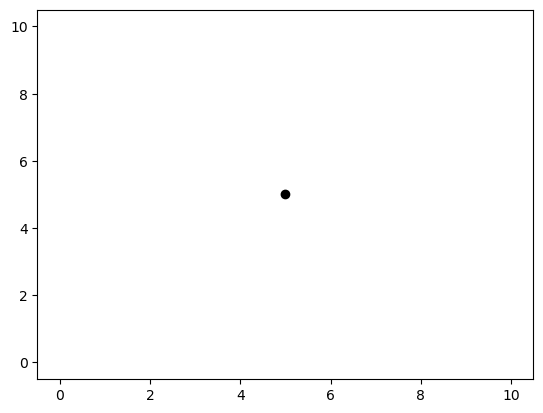

In [19]:
#plot segment lines using data gathered!
plot_x = []
plot_y = []
co = []
for i in rgb_points_left:
    plot_x.append(i['point'][0])
    plot_y.append(i['point'][1])
    colr = ()
    if isHsv:
        colr = colorsys.hsv_to_rgb(i['colour'][0], i['colour'][1], i['colour'][2])
    else:
        colr = (i['colour'][0], i['colour'][1], i['colour'][2])
    co.append(colr)

# for i in rgb_points_right:
#     plot_x.append(i['point'][0])
#     plot_y.append(i['point'][1])
#     colr = ()
#     if isHsv:
#         colr = colorsys.hsv_to_rgb(i['colour'][0], i['colour'][1], i['colour'][2])
#     else:
#         colr = (i['colour'][0], i['colour'][1], i['colour'][2])
#     co.append(colr)

plt.scatter(plot_x, plot_y, c=co)

In [20]:
#rgb_points = rgb_points_left + rgb_points_right
rgb_points = rgb_points_left

In [21]:
count = 0
#Write vertex-colour data onto txt files
vertex_reds = open("vertex_reds.txt", "w")
for point_i in all_dots_indexed:
    vertex_reds.write(f"{point_i} {rgb_points[count]['colour'][0]}\n")
    count += 1
vertex_reds.close()

count = 0
vertex_greens = open("vertex_greens.txt", "w")
for point_i in all_dots_indexed:
    vertex_greens.write(f"{point_i} {rgb_points[count]['colour'][1]}\n")
    count += 1
vertex_greens.close()

count = 0
vertex_blues = open("vertex_blues.txt", "w")
for point_i in all_dots_indexed:
    vertex_blues.write(f"{point_i} {rgb_points[count]['colour'][2]}\n")
    count += 1
vertex_blues.close()


#Write mesh generated by triangle onto obj file
obj = open("meshObj.obj", "w")
for point in meshObj['vertices']:
    obj.write(f'v {point[0]} {point[1]}  0\n')
obj.write('\n\n\n\n\n\n')
for triangle in meshObj['triangles']:
    obj.write(f'f {triangle[0] + 1} {triangle[1] + 1} {triangle[2] + 1}\n')
obj.close()

#Set up problems for PolyFEM
reds = {
    "geometry": {
        "mesh": "meshObj.obj"
    },
    "materials": {
        "type": "Laplacian"
    },
    "boundary_conditions": {
        "dirichlet_boundary": [
            "vertex_reds.txt"
        ]
    },
    "output": {
        "paraview": {
            "file_name": "red.vtu"
        }
    }
}

greens = {
    "geometry": {
        "mesh": "meshObj.obj"
    },
    "materials": {
        "type": "Laplacian"
    },
    "boundary_conditions": {
        "dirichlet_boundary": [
            "vertex_greens.txt"
        ]
    },
    "output": {
        "paraview": {
            "file_name": "green.vtu"
        }
    }
}

blues = {
    "geometry": {
        "mesh": "meshObj.obj"
    },
    "materials": {
        "type": "Laplacian"
    },
    "boundary_conditions": {
        "dirichlet_boundary": [
            "vertex_blues.txt"
        ]
    },
    "output": {
        "paraview": {
            "file_name": "blue.vtu"
        }
    }
}


#Dump problems into readable json files
with open("red.json", "w") as fp:
    json.dump(reds, fp)
    
with open("green.json", "w") as fp:
    json.dump(greens, fp)
    
with open("blue.json", "w") as fp:
    json.dump(blues, fp)


#Generate red map for object
command = ["C:\\polyfem\\out\\build\\x64-Debug\\PolyFEM_bin.exe","-j", "red.json"]
p = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

#Generate green map for object
command = ["C:\\polyfem\\out\\build\\x64-Debug\\PolyFEM_bin.exe","-j", "green.json"]
p = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

#Generate blue map for object
command = ["C:\\polyfem\\out\\build\\x64-Debug\\PolyFEM_bin.exe","-j", "blue.json"]
p = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [3]:
#isHsv = True

In [22]:
#Read files generated by PolyFEM
red = meshio.read("red.vtu")
green = meshio.read("green.vtu")
blue = meshio.read("blue.vtu")


#Use reordered faces from one of the files generated by PolyFEM (they're all ordered the same)
face_list = red.cells_dict['triangle']


#Grab generated RGB values and compile into a colour array (co), then convert to mp-readable array with numpy
co = []
for i in range(len(red.points)):
    colr = ()
    if isHsv:
        colr = colorsys.hsv_to_rgb(red.point_data['solution'][i][0], green.point_data['solution'][i][0], blue.point_data['solution'][i][0])
    else:
        colr = (red.point_data['solution'][i][0], green.point_data['solution'][i][0], blue.point_data['solution'][i][0])
    co.append(colr)
col = np.array(co)

In [23]:
#Generate 3D object!
mp.plot(red.points, face_list, c=col, return_plot=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, 5.0,…